# Curve Fitting

- [scipy](#SciPy)
- [sklearn](#SkLearn)
- [pymc](#PyMC)

## SciPy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

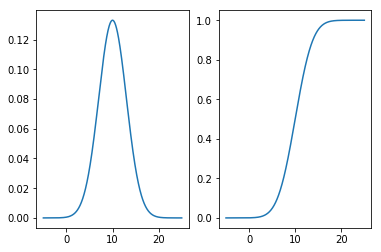

In [2]:
dist = sps.norm(loc=10,scale=3)
x = np.linspace(-5,25,1000)
plt.subplot(121)
plt.plot(x, dist.pdf(x))
plt.subplot(122)
plt.plot(x, dist.cdf(x));

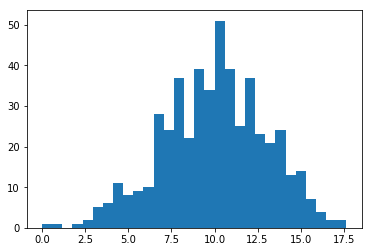

In [3]:
sampl = dist.rvs(size=500)
plt.hist(sampl, bins=30);

In [4]:
mu, sd = sps.norm.fit(sampl)
mu, sd

(10.012530772395229, 3.0030837299838464)

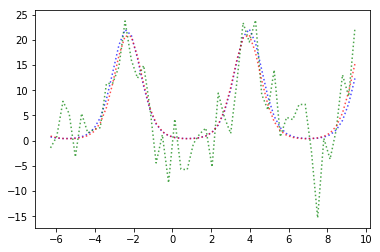

In [5]:
def func(x,a,b,f,phi):
    return a*np.exp(-b*np.sin(f*x+phi))

actual_params = [3, 2, 1, np.pi/4]
x = np.linspace(-2*np.pi, 3*np.pi)

exact = func(x, *actual_params)
noisy = exact + 5*np.random.randn(len(x))
plt.plot(x, exact, 'b:', x, noisy, 'g:', alpha=.7)

initial_guess=[1,1,1,1]
estparams,esterrs = spo.curve_fit(func, x, noisy, p0 = initial_guess)
plt.plot(x, func(x,*estparams), 'r:', label='fitted', alpha=.7);

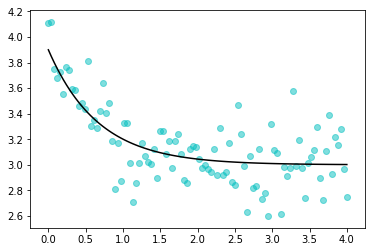

In [6]:
x = np.linspace(0, 4, 100)
y = .9*np.exp(-1.5*x) + 3
plt.plot(x, y, 'k', label='y')

noise = 0.2*sps.norm.rvs(size=100)
noisy_y = y + noise
plt.scatter(x, noisy_y, label='noisy y', c='c', alpha=.5);

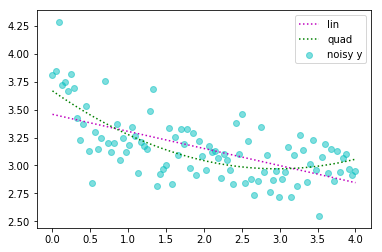

In [7]:
noise = 0.2*sps.norm.rvs(size=100)
noisy_y = y + noise
plt.scatter(x, noisy_y, label='noisy y', c='c', alpha=.5);

lincoef = np.polyfit(x, noisy_y, 1)
linpoly = np.poly1d(lincoef)
liny = linpoly(x)
plt.plot(x, liny, 'm:', label='lin')

quadcoef = np.polyfit(x, noisy_y, 2)
quadpoly = np.poly1d(quadcoef)
quady = quadpoly(x)
plt.plot(x, quady,'g:', label='quad')

plt.legend();

## sklearn

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

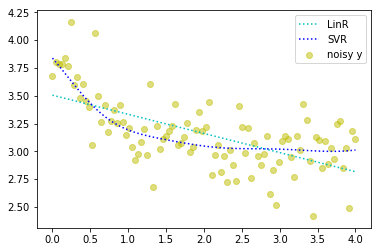

In [9]:
x = np.linspace(0, 4, 100)
y = .9*np.exp(-1.5*x)+3

noise = 0.2*sps.norm.rvs(size=100)
noisy_y = y + noise
plt.scatter(x, noisy_y, label='noisy y', c='y', alpha=.5);

model = LinearRegression()
model.fit(x[:,np.newaxis], noisy_y)
predicted = model.predict(x[:,np.newaxis])
plt.plot(x, predicted, 'c:', label='LinR')

model2 = Pipeline([
    ('standardize',StandardScaler()),
    ('svr', SVR(kernel='rbf', verbose=0, epsilon=.01)),
])
model2.fit(x[:,np.newaxis], y)
predicted2 = model2.predict(x[:,np.newaxis])
plt.plot(x, predicted2, 'b:', label='SVR')

plt.legend();

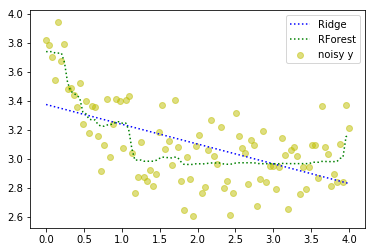

In [10]:
x = np.linspace(0,4,100)
y = .9*np.exp(-1.5*x)+3

noise = 0.2*sps.norm.rvs(size=100)
noisy_y = y + noise
plt.scatter(x, noisy_y, label='noisy y', c='y', alpha=.5)

ridgeM = Ridge(alpha=1, fit_intercept=True)
ridgeM.fit(x[:,np.newaxis], noisy_y)
ridge = ridgeM.predict(x[:,np.newaxis])
plt.plot(x, ridge, 'b:', label='Ridge')

rforestM = RandomForestRegressor(max_leaf_nodes=5, n_estimators=100)
rforestM.fit(x[:,np.newaxis], noisy_y)
rforest = rforestM.predict(x[:,np.newaxis])
plt.plot(x, rforest, 'g:', label='RForest')

plt.legend();

## PyMC

In [11]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pymc3 as pm

/home/mico/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, gamma, beta, alpha]
Sampling 8 chains: 100%|██████████| 4800/4800 [06:06<00:00,  5.85draws/s] 
The acceptance probability does not match the target. It is 0.8910742844910843, but should be close to 0.8. Try to increase the number of tuning steps.


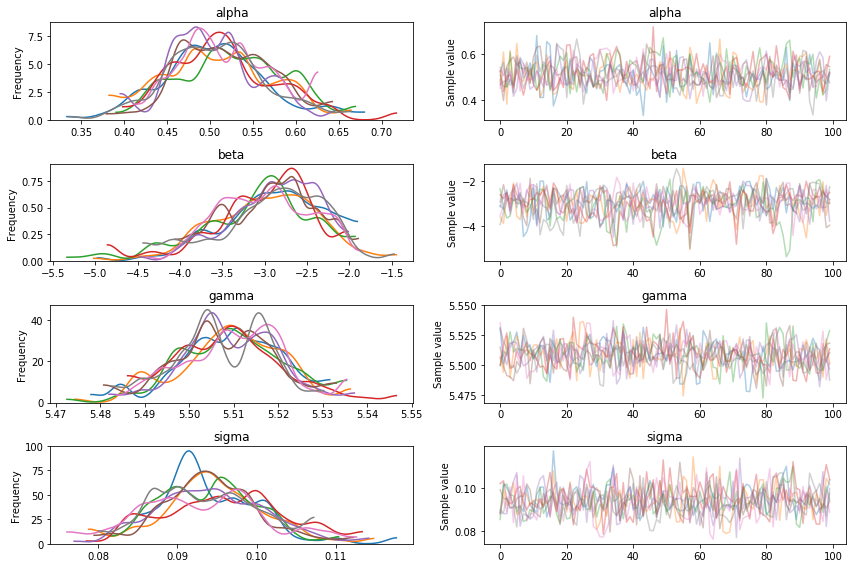

In [12]:
x = np.linspace(0,4,100)
y = .5 * np.exp(-2.5*x) + 5.5

noise = 0.1*sps.norm.rvs(size=100)
noisy_y = y + noise

trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu = 1, sd = 1)
    beta  = pm.Normal('beta', mu =-2, sd = 2)
    gamma = pm.Normal('gamma', mu = 5, sd = 3)
    sigma = pm.Uniform('sigma', lower = 0, upper = 3)
    
    y_est = alpha * np.exp(beta*x) + gamma

    likelihood = pm.Normal('y', mu = y_est, sd = sigma, observed = noisy_y)
    
    trace = pm.sample(draws=100, chains=8, cores=8)
    
    pm.traceplot(trace);

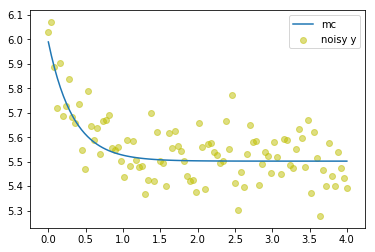

In [13]:
param_hists = [np.histogram(trace.get_values(param)) for param in trace.varnames]
param_modes = [param_hists[j][0].argmax() for j, param in enumerate(trace.varnames)]
params_d = {trace.varnames[j]:param_hists[j][1][p] for j, p in enumerate(param_modes)}

func = '{alpha} * np.exp({beta}*x)+{gamma}'.format(**params_d)
plt.plot(x[:,np.newaxis],eval(func,{'x':x[:,np.newaxis],'np':np}),label='mc')

plt.scatter(x, noisy_y, label='noisy y', c='y', alpha=.5)
plt.legend();

# THE END